# Convolutional Neural Networks in Pytorch

10 classes, 60000 pics. Multilabel classification.

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split

project_name='06-cifar10-cnn'

# Download data from fastai
from torchvision.datasets.utils import download_url
dataset_url = 'http://files.fast.ai/data/cifar10.tgz'
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [2]:
# Extract from archive
import tarfile
# r:gz - open for reading with gz compression
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [3]:
!ls data/cifar10

labels.txt  test  train


In [4]:
!cat data/cifar10/labels.txt

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


In [5]:
# Instead of magic commands
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'labels.txt', 'train']
['ship', 'cat', 'automobile', 'truck', 'airplane', 'horse', 'frog', 'bird', 'deer', 'dog']


In [6]:
# Checking inside airplane folder
airplane_files = os.listdir(data_dir + '/train/airplane')
print('No of airplane training images = ', len(airplane_files))
print(airplane_files[:5])

No of airplane training images =  5000
['44968_airplane.png', '185_airplane.png', '41751_airplane.png', '41664_airplane.png', '5082_airplane.png']


In [7]:
# In most image problems, this kind of a directory structure is maintained
# inside the data folder, there are train and test folders
# in each of them, there are folders whose names are depicting the labels
# in those folders there are individual images
# We can use ImageFolder class from torchvision

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(root=data_dir+'/train', transform=ToTensor())

In [8]:
print(len(dataset))

# Taking the first image and its label
img, label = dataset[0]
print(img.shape) # Color depth, length, breadth
print(label)

50000
torch.Size([3, 32, 32])
0


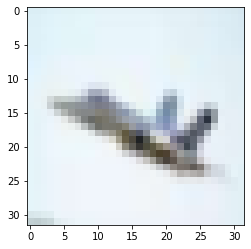

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0)) # Since matplot expects color depth to be last, permute

In [10]:
# How do we know that label, which is set as 0 is airplane?
# In other words, the label encoding scheme
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

label is 1 which is  automobile


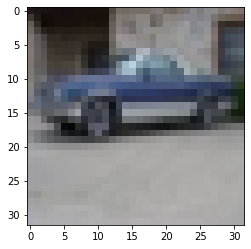

In [11]:
def show_example(img, label):
    print('label is {} which is '.format(label), dataset.classes[label])
    plt.imshow(img.permute(1,2,0))

show_example(*dataset[5000]) # same as show_example(dataset[5000][0], dataset[5000][1])

In [12]:
# TrainTestSplit
from torch.utils.data import random_split
random_seed = 0
torch.manual_seed(random_seed)

val_size = 5000 # 10 percent val
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

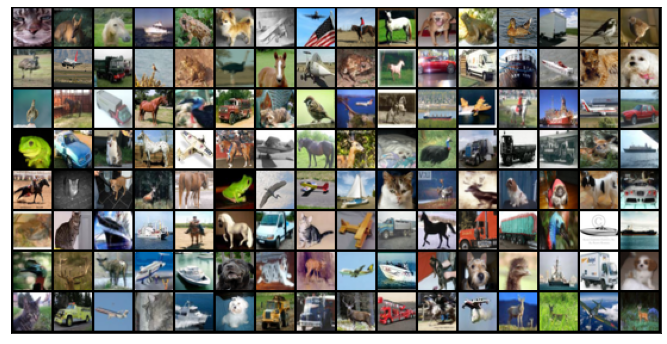

In [13]:
# Create train and validation data loaders
from torch.utils.data.dataloader import DataLoader

batch_size = 128

train_dl = DataLoader(dataset=train_ds,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
val_dl = DataLoader(dataset=val_ds,
                    batch_size=batch_size*2,
                    shuffle=False,
                    num_workers=4,
                    pin_memory=True)

# Visualizing a batch
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break;

show_batch(train_dl) 

In [14]:
# Modeling
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

# Base class that contains helper methods for training and validation
# Inheriting from nn.Module because this will be the parent class for our model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        # .detach() is used to construct a new view of the tensor that is declared not to need gradients
        # It is excluded from further tracking of operations
        # See http://www.bnikolic.co.uk/blog/pytorch-detach.html for more intel
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print('Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, 
                                                                                         result['train_loss'],
                                                                                         result['val_loss'],
                                                                                         result['val_acc']))

# Use nn.Sequential() just like tf.keras.models.Sequential([])
# Inherit from ImageClassificationBase which inherits from nn.Module
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # images are having a depth of 3, convert it into 32 depths
            # ie number of filters is 32, lenght and width remains the same (32,32)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            # take 32 filter representations and convert them into 64 representations
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # MaxPool of size 2x2 striding 2 steps will reduce the length and breadth of images by half
            nn.MaxPool2d(kernel_size=2, stride=2),
            # now the output is 64x16x16
            # ie 64 different representations of the same 16x16 shaped image

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Now output is 128 representations of 8x8 image ie 128x8x8

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 256x4x4

            nn.Flatten(),
            nn.Linear(in_features=256*4*4, out_features=1024), # out is 1024 sized 1d tensor
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512), # out is 512 sized 1d tensor
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=10) # out is 10 sized 1d tensor
        )
    
    def forward(self, xb):
        return self.network(xb)

In [15]:
model = Cifar10CnnModel(); model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features

In [16]:
# Testing the model without training
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0044, -0.0335, -0.0108,  0.0388,  0.0392, -0.0046,  0.0330,  0.0031,
         0.0152, -0.0350], grad_fn=<SelectBackward>)


In [17]:
out[0].sum() # softmax/max able

tensor(0.0411, grad_fn=<SumBackward0>)

In [18]:
# GPU biolerplate chooser
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# Move tensor to chosen device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    # i/o time of data transfer should not block non dependent execution of the kernel
    return data.to(device, non_blocking=True)

# Wrap dataloader to move data to device
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    # Yield a batch of data after moving it to device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    # number of batches
    def __len__(self):
        return len(self.dl)

device = get_default_device(); device

device(type='cuda')

In [19]:
# Wrap the training and validation dataloaders in DeviceDataLoader
# for automatically transfering batches to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Moving model to device
to_device(model, device); # ; to Suppress model printing

In [20]:
# Training the Model
# function decorator to tell pytorch that when executing function evaluate(), do not track gradients
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history=[]
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result) # Verbose
        history.append(result)
    return history

In [21]:
# Final eval without training
model = to_device(Cifar10CnnModel(), device) # moving to gpu
evaluate(model, val_dl) # Expecting 1 in 10 to be correct as there are 10 classes which are hopefully stratified in batch

{'val_acc': 0.09996552765369415, 'val_loss': 2.303053379058838}

In [22]:
# Training 
num_epochs = 10
adam_opt_func = torch.optim.Adam
lr = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl, adam_opt_func)

Epoch [0], train_loss: 1.7969, val_loss: 1.4474, val_acc: 0.4666
Epoch [1], train_loss: 1.2735, val_loss: 1.1271, val_acc: 0.5954
Epoch [2], train_loss: 1.0182, val_loss: 0.9014, val_acc: 0.6727
Epoch [3], train_loss: 0.8455, val_loss: 0.8324, val_acc: 0.7034
Epoch [4], train_loss: 0.7078, val_loss: 0.7933, val_acc: 0.7358
Epoch [5], train_loss: 0.5863, val_loss: 0.7276, val_acc: 0.7512
Epoch [6], train_loss: 0.4924, val_loss: 0.7107, val_acc: 0.7662
Epoch [7], train_loss: 0.4077, val_loss: 0.7606, val_acc: 0.7565
Epoch [8], train_loss: 0.3268, val_loss: 0.7697, val_acc: 0.7589
Epoch [9], train_loss: 0.2554, val_loss: 0.8031, val_acc: 0.7718


In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs Epochs')

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'])
    plt.title('Loss vs Epochs')

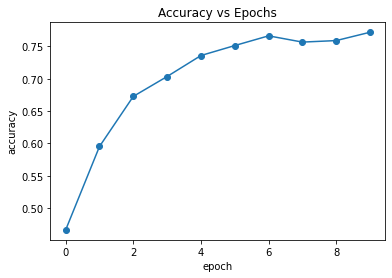

In [28]:
plot_accuracies(history)

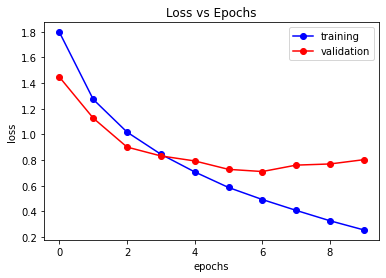

In [30]:
plot_losses(history)

In [31]:
# Testing with individual Images
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # predict
    yb = model(xb)
    # pick index witht highest probability
    _, preds = torch.max(yb, dim=1)
    # retrieve class label
    return dataset.classes[preds[0].item()]

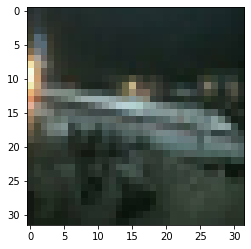

In [33]:
img, label = test_dataset[0]
plt.imshow(img.permute(1,2,0))

In [34]:
dataset.classes[label] # Actual

'airplane'

In [35]:
predict_image(img, model)

'airplane'

In [36]:
# Finding the overall loss and accuracy on the test set
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader); result

{'val_acc': 0.7705078125, 'val_loss': 0.8123922348022461}

In [39]:
# Saving and Loading the model
# model.state_dict() # gives an ordered dict containing the weights
torch.save(model.state_dict(), 'cifar10-cnn.pth')
# to load this, use.load_state_dict()

model2 = to_device(Cifar10CnnModel(), device)
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [41]:
evaluate(model2, test_loader)

{'val_acc': 0.7705078125, 'val_loss': 0.8123922348022461}